In [288]:
# Initialize Otter
import otter
grader = otter.Notebook()

In [289]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression

# Project 2: Logistic Regression and Classification
## Due Date:  Wednesday November 30th, 11:59 PM

## This Assignment

In this project, you will be attempting to predict whether a flight will be delayed or not depending on measureable characteristics about the flight. You will:

1) Perform some initial exploratory data analysis

2) Fit models of varying complexity and evaluate which is best

3) Assess how adjusting the classification threshold affects different metrics of your classifier


## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the assignment, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

### Read in airport data

In [290]:
# Read in flight delays
delays = pd.read_csv("./data/flightdelay.csv")
# Read in airport coordinates
airport_coord = pd.read_csv("./data/airport_coordinates.csv")

In [291]:
delays.head()

,Unnamed: 0,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,PLANE_AGE,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND
0,202348,1,7,0,0700-0759,1,1,29,76,Endeavor Air Inc.,10278,19857,10,John F. Kennedy International,NONE,0.0,0.0,0.0,33.0,11.41
1,4309162,8,7,1,2100-2159,11,5,3,181,Alaska Airlines Inc.,1427,24460,3,Keahole,Seattle International,0.0,0.0,0.0,88.0,9.62
2,2944942,6,2,1,1200-1259,10,2,26,154,United Air Lines Inc.,5971,53737,21,Washington Dulles International,Orlando International,0.0,0.0,0.0,87.0,4.70
3,2863511,6,7,0,1600-1659,3,3,5,76,SkyWest Airlines Inc.,9694,71188,2,Salt Lake City International,San Francisco International,0.0,0.0,0.0,86.0,15.21
4,5738468,11,1,0,0800-0859,1,2,31,76,Endeavor Air Inc.,12563,20783,10,Logan International,Greater Buffalo International,0.0,0.0,0.0,54.0,8.50


In [292]:
airport_coord.head()

,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,AFOGNAK_LAKE_AIRPORT,58.109444,-152.906667
1,BEAR_CREEK_MINING_STRIP,65.548056,-161.071667
2,LIK_MINING_CAMP,68.083333,-163.166667
3,LITTLE_SQUAW_AIRPORT,67.570000,-148.183889
4,KIZHUYAK_BAY,57.745278,-152.882778


You should reference raw data documention included in the data folder to evaluate the meaning of each variable. In particular, be sure to identify the variable representing our "target" in this assignment: whether a flight is delayed or not. 

## Part 1: Initial cleaning

Again, our objective in this project is to **develop a model that can predict whether a flight will be delayed or not** to some efficacy.

Before we start cramming features into different models, we should first do some data visualization to develop some intuition for which variables might be predictive of flight delays.

#### Question 1.1
Two variables we might be interested in - latitude and longitude - are in a separate table called `airport_coord`. Let's get everything in one object. Canonicalize the airport names in `delays` and `airport_coord` so that they can be joined. 

In [293]:
delays['DEPARTING_AIRPORT'] = delays['DEPARTING_AIRPORT'].str.lower().replace('_', ' ', regex = True)
airport_coord['DISPLAY_AIRPORT_NAME'] = airport_coord['DISPLAY_AIRPORT_NAME'].str.lower().replace('_', ' ', regex = True)

#### Question 1.2

Now add latitude and longitude columns to the `delays` by merging the datasets on `DEPARTING_AIRPORT` in `delays`. NA values are a problem for model fitting, so drop all NAs in the data.

In [294]:
delays = delays.merge(airport_coord, left_on = "DEPARTING_AIRPORT", right_on = 'DISPLAY_AIRPORT_NAME')
delays

,Unnamed: 0,MONTH,DAY_OF_WEEK,DEP_DEL15,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,...,DEPARTING_AIRPORT,PREVIOUS_AIRPORT,PRCP,SNOW,SNWD,TMAX,AWND,DISPLAY_AIRPORT_NAME,LATITUDE,LONGITUDE
0,202348,1,7,0,0700-0759,1,1,29,76,Endeavor Air Inc.,...,john f. kennedy international,NONE,0.00,0.0,0.0,33.0,11.41,john f. kennedy international,40.638611,-73.776944
1,5841131,11,2,0,2100-2159,2,6,16,50,Endeavor Air Inc.,...,john f. kennedy international,Portland International Jetport,0.02,0.0,0.0,58.0,17.67,john f. kennedy international,40.638611,-73.776944
2,1103561,3,5,0,1900-1959,5,4,27,191,Delta Air Lines Inc.,...,john f. kennedy international,Fort Lauderdale-Hollywood International,0.00,0.0,0.0,59.0,6.93,john f. kennedy international,40.638611,-73.776944
3,3120058,6,3,0,0700-0759,3,2,26,150,JetBlue Airways,...,john f. kennedy international,John F. Kennedy International,0.00,0.0,0.0,82.0,10.51,john f. kennedy international,40.638611,-73.776944
4,751743,2,1,0,0800-0859,4,2,35,70,SkyWest Airlines Inc.,...,john f. kennedy international,Pittsburgh International,0.10,0.0,0.0,42.0,14.09,john f. kennedy international,40.638611,-73.776944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324448,2536426,5,3,0,0900-0959,3,2,2,178,Spirit Air Lines,...,myrtle beach international,Nafec Atlantic City,0.12,0.0,0.0,76.0,5.37,myrtle beach international,33.679167,-78.929722
324449,3350762,7,2,0,1000-1059,2,3,4,149,Delta Air Lines Inc.,...,myrtle beach international,Atlanta Municipal,0.08,0.0,0.0,87.0,3.80,myrtle beach international,33.679167,-78.929722
324450,3154032,6,6,0,1700-1759,2,5,6,90,Comair Inc.,...,myrtle beach international,Philadelphia International,0.00,0.0,0.0,88.0,11.63,myrtle beach international,33.679167,-78.929722
324451,3712889,7,4,0,0700-0759,1,1,2,128,American Airlines Inc.,...,myrtle beach international,NONE,0.00,0.0,0.0,89.0,6.26,myrtle beach international,33.679167,-78.929722


Be sure that the target variable is encoded as an integer.

In [295]:
delays["DEP_DEL15"] = delays["DEP_DEL15"].astype(int)

In [296]:
grader.check("q1_3")

q1_3 results: All test cases passed!

## Part 2: Variable exploration

A sensible early step in this process will be to assess whether certain variables associate with the likelihood of delays first and let that guide our modeling decisions.

#### Question 2.1

Create an appropriate figure to visualize the relationship between the probability of a delay and the month of the year

Text(0.5, 1.0, 'Probability of Flight Delay by Month')

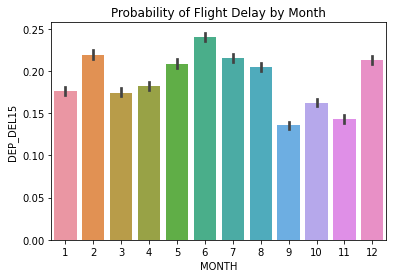

In [297]:
sns.barplot(data = delays, x = "MONTH", y = "DEP_DEL15")
plt.title("Probability of Flight Delay by Month") 

#### Question 2.2

Based on your visualization, what times of year appear to see more flight delays? Can you infer why this might be the case?

**Your response**: Based on the visualization it looks like february, May through August, and December all seem to experience higher probabilities of a delayed flights, as all their chances of delay are greater than 20%. For February and December this makes sense as Valentines and Christmas might cause an increased volume in traveling along with winter weather conditions potentially playing an effect. For May through August these are peak summer months and many people use this time to travel and with the increased volume of people traveling that also might increase the air traffic which in turn could increase flight delays. 

#### Question 2.3 

What about the time of day for a flight's departure? Create a visualization as above, but this time representing the probability of flight delay by departure window.

Note that you should first engineer this feature such that it represents a quantitative variable. There are many approaches to this, but your resulting variable should represent the hour as a quantitative variable in even increments.

In [298]:
delays['DEP_TIME_BLK'] = pd.to_datetime(delays['DEP_TIME_BLK'].str[:4], format = "%H%M").dt.hour

Text(0.5, 1.0, 'Probability of Flight Delay by Hour')

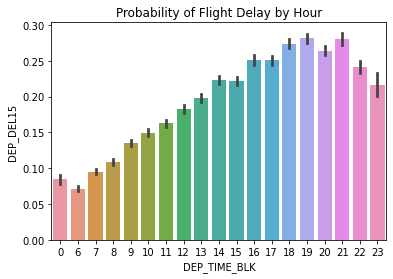

In [299]:
sns.barplot(data = delays, x = "DEP_TIME_BLK", y = "DEP_DEL15")
plt.title("Probability of Flight Delay by Hour") 

#### Question 2.4

How does the probability of a delay change with the hour of departure? Why do you think this might be?

**Your response**: The probabilty of delay slightly increases each hour starting at 6am and peaking at 7pm or 9pm. This could be because most people like to fly in the afternoon or nighttime and so airport traffic and maybe air traffic is also busier which could be causing higher delays during these hours. 

#### Question 2.5

Choose two other variables and create an effective visualization of their relationship to flight delays. Note that if you choose a continuous quantitative variable, you might need to create a model to visualize the relationship (*e.g.* a logistic regression curve). 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Endeavor Air Inc.'),
  Text(1, 0, 'Delta Air Lines Inc.'),
  Text(2, 0, 'JetBlue Airways'),
  Text(3, 0, 'SkyWest Airlines Inc.'),
  Text(4, 0, 'American Airlines Inc.'),
  Text(5, 0, 'American Eagle Airlines Inc.'),
  Text(6, 0, 'Midwest Airline, Inc.'),
  Text(7, 0, 'Alaska Airlines Inc.'),
  Text(8, 0, 'Comair Inc.'),
  Text(9, 0, 'Hawaiian Airlines Inc.'),
  Text(10, 0, 'United Air Lines Inc.'),
  Text(11, 0, 'Southwest Airlines Co.'),
  Text(12, 0, 'Mesa Airlines Inc.'),
  Text(13, 0, 'Atlantic Southeast Airlines'),
  Text(14, 0, 'Frontier Airlines Inc.'),
  Text(15, 0, 'Spirit Air Lines'),
  Text(16, 0, 'Allegiant Air')])

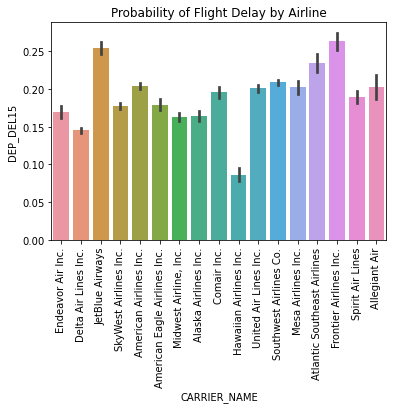

In [300]:
# Exploration 1
sns.barplot(data = delays, x = "CARRIER_NAME", y = "DEP_DEL15")
plt.title("Probability of Flight Delay by Airline") 
plt.xticks(rotation = 90)

# It looks like JetBlue Airways and Frontier Airlines Inc. are only two airlines with with flight delays over 25% in probability. 

Text(0, 0.5, 'Probability of Delay')

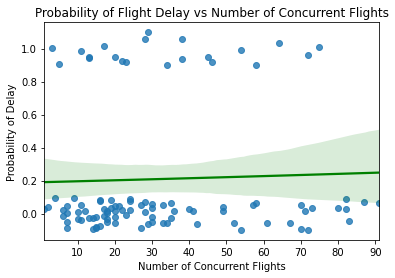

In [302]:
# Exploration 2
# sampled_data = delays.sample(n = 10000) #It took a few minutes when I didn't sample it first
sns.regplot(data=sampled_data, x='CONCURRENT_FLIGHTS', y='DEP_DEL15', logistic=True, y_jitter = 0.1, line_kws={"color": "green"})
plt.title("Probability of Flight Delay vs Number of Concurrent Flights")
plt.xlabel('Number of Concurrent Flights')
plt.ylabel('Probability of Delay')

## Part 3: Fitting and evaluating models

In this section we are going to develop a series of models that will predict the probability of delay from some number of input features. We will ultimately assess which of these models is best using *k-fold* cross-validation. 

#### Question 3.1

**Create 4 sets of predictive features**, each with a different combination of features that you feel may be apt for predicting delays. Ensure that you have different numbers of features in each set, and have one set with at least 8 features.

*Note*: We are using subset selection to explore effective models. You do not need to standardize your features, though you may find it helpful for fitting your more complicated models.

In [303]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
continuous_features = delays[["LATITUDE", "LONGITUDE", "AWND", "TMAX", "SNOW", "PRCP", "SNWD", "CONCURRENT_FLIGHTS", "DISTANCE_GROUP", "SEGMENT_NUMBER", "NUMBER_OF_SEATS"]]
scaled_feats = scaler.fit_transform(continuous_features)

m1_cat = pd.DataFrame(delays, columns = ["MONTH", "DAY_OF_WEEK"])
m1_scaled = pd.DataFrame(scaled_feats[:,[3]], columns = ["TMAX"])
m1_features = pd.concat([m1_cat, m1_scaled], axis = 1)

m2_cat = pd.DataFrame(delays, columns = ["MONTH"])
m2_scaled = pd.DataFrame(scaled_feats[:, 2:6], columns = ["AWND", "TMAX", "SNOW", "PRCP"])
m2_features = pd.concat([m2_cat, m2_scaled], axis = 1)

m3_features = pd.DataFrame(scaled_feats[:, 0:8], columns = ["LATITUDE", "LONGITUDE", "AWND", "TMAX", "SNOW", "PRCP", "SNWD", "CONCURRENT_FLIGHTS"])

m4_features = pd.DataFrame(scaled_feats[:, [4]], columns = ["SNOW"])

#### Question 3.2

Now use your features to develop 4 logistic regression models, using *k-fold* cross-validation to determine the error associated with each model. Use 5 splits for your cross-validation, and be sure to use the appropriate loss function to calculate your error. 

In [304]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

model_m1 = LogisticRegression()
model_m2 = LogisticRegression()
model_m3 = LogisticRegression()
model_m4 = LogisticRegression()

X1 = m1_features
X2 = m2_features
X3 = m3_features
X4 = m4_features
Y = delays["DEP_DEL15"]

avg_error_m1 = compute_CV_error(model_m1, X1, Y)
avg_error_m2 = compute_CV_error(model_m2, X2, Y)
avg_error_m3 = compute_CV_error(model_m3, X3, Y)
avg_error_m4 = compute_CV_error(model_m4, X4, Y)

avg_errors = [avg_error_m1, avg_error_m2, avg_error_m3, avg_error_m4]
for i, errors in enumerate(avg_errors):
    print(f"Average Log Loss for Model {i+1}: {errors}")

Average Log Loss for Model 1: 0.4862189619241969
Average Log Loss for Model 2: 0.48205307417768173
Average Log Loss for Model 3: 0.4825895587808907
Average Log Loss for Model 4: 0.4852938809946224


In [305]:
def compute_CV_error(model, X_train, Y_train):
    
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]
        
        model.fit(split_X_train, split_Y_train)
        Y_pred = model.predict_proba(split_X_valid)
        
        error = log_loss(split_Y_valid, Y_pred)
        validation_errors.append(error)
    
    return np.mean(validation_errors)

#### Question 3.3

Which model best fit your data? Why do you think it fit your data better compared to your other models?

**Your response**: All of the models fit the data just about the same but model 2 marginally fits the data best at about 0.4820 average loss. This could be because it was a more balanced number of variables compared to the other models. Model 2 used 5 variables as predictors compared to the other models which used 3, 8, and 1 predictor variables. Too many variables might cause and overfit while too little variables might cause an underfit. With such little differences in log loss between the models though it seems that all of the variables have similar predictive capabilities. Maybe this is because flight delays are pretty unpredictable and so each variable used here has an equally likely chance to predict if a flight will be delayed or not. 

### Question 4

Finally, let's calculate the accuracy, precision and recall of your model. 

#### Question 4.1

Predict a 0 or a 1 (no delay or delay) using your x holdout data. Then using your y holdout data, quantify the number of true positives, true negatives, false positives, and false negatives. Use the `model.predict()` function to do so. 

In [1]:
from sklearn.metrics import confusion_matrix
np.random.seed(25)
X_train2, X_holdout2, Y_train2, Y_holdout_2 = train_test_split(X2, Y, test_size = 0.10)

# Trained
trained = model_m2.fit(X_train2, Y_train2)
# Predcitions
Y_holdout_pred = model_m2.predict(X_holdout2)
# Confusion matrix 
cm = confusion_matrix(Y_holdout_2, Y_holdout_pred)

FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

# Precision or positive predictive value
PPV = TP/(TP+FP)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(f"False Positive: {FPR} and False Negative: {FNR}")

NameError: name 'np' is not defined

In [307]:
accuracy = ACC
precision = PPV
recall = TPR

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = [0.81181039 0.81181039], precision = [0.81248841 0.5375    ], and recall = [0.99859497 0.00703534]


#### Question 4.2

Presume that you're interested in using your model as a decision-making tool to decide if a flight you've booked will be delayed. Do you think your model will is useful for this and why or why not?

**Your response**: No I don't believe its very useful for predicting flight delays. The recall for predicting delays is only 0.7% which is not nearly good enough for me to feel comfortable using it as a decision making tool. It's also worth seeing that the precision for predicting delays is 53.75% so even when the model predicts a delay it is only right just over half of the time. Accuracy however does seem reasonably high at 81.11% but this could be because the models ability to correctly predict no delays is so high at 99.85%. Overall the model is not useful for its intended purpose of predicting flight delays but it is pretty good at prediciting flights that won't be delayed. 

#### Question 4.3

`sklearn.model.predict` uses a threshold of p=0.5 by default when predicting a 0 or 1 from your logistic model. Perhaps this threshold was too ambitious. Unless you found a *much* better model that I did, you likely predicted very few flight delays with >50% likelihood. Let's move forward by thinking of our model as a tool for flagging flights to watch out for instead.

First, calculate the proportion of all flights delayed in the dataset. 

In [308]:
prop_delayed = np.sum(delays["DEP_DEL15"] == 1) / len(delays["DEP_DEL15"])

In [309]:
grader.check("q4_3")

q4_3 results: All test cases passed!

#### Question 4.4

This may represent a better baseline for our threshold than 0.5. Note that this will change our interpretation of a predicted class of 1; rather than a 1 representing a flight we think is *likely* to be delayed, a 1 will represent a flight we think has a *better chance than average* to be delayed. 

Using your best model, use `model.predict_proba()` to

1) Return the predicted probabilties $[p_0, p_1]$ 

2) Identify which predictions have a $p_1$ greater than `prop_delayed` and classify these as 1

3) Recalculate accuracy, precision, and recall

In [311]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
predicted_probabilities = model_m2.predict_proba(X_holdout2)
# predicted_probabilities
preds_greater = (predicted_probabilities[:, 1] > prop_delayed).astype(int)

In [312]:
accuracy = accuracy_score(Y_holdout_2, preds_greater)
precision = precision_score(Y_holdout_2, preds_greater)
recall = recall_score(Y_holdout_2, preds_greater)

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = 0.634099734944215, precision = 0.23636030757964116, and recall = 0.4224476439790576


#### Question 4.5

How did lowering the threshold of your classifier change its precision and recall, and what does this mean in terms of predicting flight delays?

**Your response**: Lowering the threshold of the classifer significantly lowered precision and increased recall. This means that when the model predicts a flight will be delayed, only about 23.63% of these predicted flights will actually be delayed. The models recall went up to 42.24% meaning that the model will correctly predict 42.24% of all actual delays. This makes the model more sensitive to actual delays but also more likely to have false positives. The higher recall indicates that there is less chance of missing a real delay because the model is now more adept at identifying possible delays. The downside is that more flights are incorrectly reported as delayed.

#### Question 4.6

Create a new variable representing a completely random guess for a flight delay, weighted by the observed likelihood of a delay. Calculate the accuracy, precision, and recall of your random guesses. 

How does your best model with this new threshold perform compared to a completely random guess? What does this imply about the usefulness of your model as a decision-making tool?

In [313]:
n = len(Y_holdout_2)
random_guess = np.random.choice([0, 1], size = n, p = [1 - prop_delayed, prop_delayed])
accuracy = accuracy_score(Y_holdout_2, random_guess)
precision = precision_score(Y_holdout_2, random_guess)
recall = recall_score(Y_holdout_2, random_guess)
print(f"Accuracy = {accuracy}, Precision = {precision}, and Recall = {recall}")

Accuracy = 0.6914257535597609, Precision = 0.18609143593045718, and Recall = 0.18913612565445026


**Your response**: In comparing accuracy, precision, and recall between a random guess and my best model, accuracy is about 6%  higher in the random guess, precision is about 4% worse in the random guess, and recall is about 23% worse in the random guess. Overall it does show the model is more useful than a random guess as a 23% increase in recall is important for situations like this where predicting flight delays might be more important than a higher accuracy. The fact that a completely random guess outperformed the model at all exposes the models predictive capabilities but I would still use it over a completely random guess as a decision making tool when trying to anticipate flight delays. 

#### Question 4.7

Do flight delays seem relatively easy or challenging to predict? Why?

**Your response**: They seem relatively challenging to predict. The complexity seems to come from the predictive power of the variables themselves where so far in my analyses none of the variables used seemed to outperform the others in predicting if a flight would be delayed or not. Many of these factors can contribute to a flight being delayed but with no single factor or combination of them offering a strong predictive ability it makes it quite challenging to predict a flights delay. It also might be worth noting some of these variables (such as AWND or TMAX) are weather conditions which can also be quite unpredictable and so might contribute to the difficulty of making a highly predictive model. Overall, the absence of a dominant predictive variable(s) and the unpredictable key factors going into the model makes predicting flight delays challenging. 

### Question 5

#### Question 5.1

Use 5-fold cross-validation to compare the fit of every one of the following univariate predictors of delay: 

`['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']`

You sould therefore be cross-validating 12 single-feature models. Then, rank the predictors in order of best to worst fit.

Next, create 8 logistic models with increasing numbers of predictors, starting with the best feature and then progressively adding the next best feature up to 8. This is called **forward step-wise subset selection**. If you run into fitting problems at the upper range of these models, be sure to standardize your variables and fit up to the number of features you're able to. 

Using the same threshold technique as in Q4.4, calculate the test data accuracy, precision and recall of the best model as determined by cross-validation. 

In [314]:
# 12 models
Y = delays["DEP_DEL15"]
features = ['MONTH', 'DAY_OF_WEEK', 'DISTANCE_GROUP', 'SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'PLANE_AGE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'AWND']

cv_errors = {}

X_train_f, X_holdout_f, Y_train_f, Y_holdout_f = train_test_split(delays[features], delays["DEP_DEL15"], test_size=0.2)

for feature in features:
    X_train = X_train_f[[feature]]
    model = LogisticRegression()
    cv_error = compute_CV_error(model, X_train, Y_train_f)
    cv_errors[feature] = cv_error

In [315]:
# Rank the predictors
ranked = sorted(cv_errors.items(), key = lambda x: x[1], reverse = True)
ranked

[('DAY_OF_WEEK', 0.48615794815459246),
 ('PLANE_AGE', 0.4861408077341912),
 ('CONCURRENT_FLIGHTS', 0.48610312119004),
 ('TMAX', 0.48609113887397964),
 ('NUMBER_OF_SEATS', 0.48604542660290073),
 ('MONTH', 0.4859974688338073),
 ('DISTANCE_GROUP', 0.48596580641945986),
 ('SNWD', 0.48583513044864857),
 ('SNOW', 0.4851235796670135),
 ('AWND', 0.484798442055956),
 ('PRCP', 0.483174672633675),
 ('SEGMENT_NUMBER', 0.4795996923594257)]

In [324]:
def compute_CV_error_2(model, X_train, Y_train):
    kf = KFold(n_splits=5)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Use standard NumPy array slicing
        # No .iloc this time
        split_X_train, split_X_valid = X_train[train_idx], X_train[valid_idx]
        split_Y_train, split_Y_valid = Y_train[train_idx], Y_train[valid_idx]
        
        model.fit(split_X_train, split_Y_train)
        Y_pred = model.predict_proba(split_X_valid)
        
        error = log_loss(split_Y_valid, Y_pred)
        validation_errors.append(error)
    
    return np.mean(validation_errors)

In [332]:
# 8 models, stepwise subset selection
ranked_features = ["DAY_OF_WEEK", 'PLANE_AGE', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS', 'DISTANCE_GROUP', 'MONTH', 'TMAX', 'SNWD', 'SNOW', 'AWND', 'PRCP', 'SEGMENT_NUMBER']
scaled = scaler.fit_transform(delays[ranked_features])

X_train_f, X_holdout_f, Y_train_f, Y_holdout_f = train_test_split(scaled, delays["DEP_DEL15"], test_size=0.2)
Y_train_f = Y_train_f.reset_index(drop = True)
avg_errors = []

for i in range(8):
    X_train_subset = X_train_f[:, :i+1]
    model = LogisticRegression()
    cv_error = compute_CV_error_2(model, X_train_subset, Y_train_f)
    avg_errors.append(cv_error)

for i, errors in enumerate(avg_errors):
    print(f"Average Log Loss for Model {i+1}: {errors}")

Average Log Loss for Model 1: 0.4870022157227142
Average Log Loss for Model 2: 0.4869840195021009
Average Log Loss for Model 3: 0.4869564271847019
Average Log Loss for Model 4: 0.4868501398057224
Average Log Loss for Model 5: 0.4867605369866809
Average Log Loss for Model 6: 0.4865713911517412
Average Log Loss for Model 7: 0.48654169312491347
Average Log Loss for Model 8: 0.4863209943237129


In [345]:
# Best model accuracy, precision, recall
best_model = LogisticRegression()
best_X_train = X_train_f[:, :8] 
best_model.fit(best_X_train, Y_train_f) 

# Predicting probabilities on the holdout set
predicted_probabilities = best_model.predict_proba(X_holdout_f[:, :8])

prop_delayed = np.mean(Y_train_f)

# Generate predictions based on the new threshold
preds_greater = (predicted_probabilities[:, 1] > prop_delayed).astype(int)

accuracy = accuracy_score(Y_holdout_f, preds_greater)
precision = precision_score(Y_holdout_f, preds_greater)
recall = recall_score(Y_holdout_f, preds_greater)

print(f"Model accuracy = {accuracy}, precision = {precision}, and recall = {recall}")

Model accuracy = 0.5483349000631829, precision = 0.20113077164694795, and recall = 0.47307502873091445


#### Question 5.2

Was the model with the best CV score the most complex model? If yes, why might complexity not have been a problem in this case? If no, why might a simpler model outperform the full model?

**Your response**: Yes the model with all 8 predictors gave the least amount of loss which was the best CV score. This shows complexity might not have been a problem in this case. Instead, each additional predictor added meaningful information to the models ability to distinguish between delayed and non-delayed flights. The added variables didn't seem to lead to overfitting since the model improved as it became more complex. My gut tells me that these specific predictors are a good fit for the model's complexity which allow it to better reflect the underlying patterns in the flight delay data.

## Submission

Congratulations! You are finished with this assignment.

To double-check your work, the cell below will rerun all of the autograder tests.

In [346]:
grader.check_all()

q1_3 results: All test cases passed!

q4_3 results: All test cases passed!

Make sure you have run all cells in your notebook in order. Then execute the following commands in the File menu:

* Save and Checkpoint
* Close and Halt

Then submit your notebook for Canvas Assignment Project 2.